### Necessary Packages

In [1]:
import torch
import pandas as pd
import numpy as np
import sys
import dotenv
import os
import torchmetrics
import torch
import seaborn as sns
sys.path.append('../..')
from src.models import ResNet34
from torchsummary import summary
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose,ToTensor
from src.transforms import LabelMapper
from src.utils import load_model_from_folder
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,recall_score,precision_score


### Setup the code to be device agnostic

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.type)

cuda


### Load envirement variables

In [3]:
PATCHES_DIR = dotenv.get_key(dotenv.find_dotenv(), "PATCHES_DIR")
MODELS_DIR = dotenv.get_key(dotenv.find_dotenv(), "MODELS_DIR")
TRAIN_DIR = os.path.join(PATCHES_DIR, "train")
VAL_DIR = os.path.join(PATCHES_DIR, "val")

print(MODELS_DIR)
print(PATCHES_DIR)
print(TRAIN_DIR)
print(VAL_DIR)

/home/abdelnour/Documents/4eme_anne/S2/projet/models
/home/abdelnour/Documents/4eme_anne/S2/projet/data/patched
/home/abdelnour/Documents/4eme_anne/S2/projet/data/patched/train
/home/abdelnour/Documents/4eme_anne/S2/projet/data/patched/val


### Global

In [4]:
BATCH_SIZE = 512

### Load the model

In [5]:
model = ResNet34(n_classes=3).to(device)

In [6]:
weights_folder = os.path.join(MODELS_DIR, "resnet34")
load_model_from_folder(model, weights_folder, verbose=True)

loading weights with name : 1710543530.8453307.pt


In [7]:
summary(model, input_size=(3,224,224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### Data Loading

In [8]:
label_mapper = LabelMapper({
    0:0, # 0 is the label for benign (BY)
    1:0, 
    2:0,
    3:1, # 1 is the label for atypical (AT)
    4:1,
    5:2, # 2 is the label for malignant (MT)
    6:2,
})

In [9]:
class RoIDataset(ImageFolder):

    def __getitem__(self, index: int):
        x,y = super().__getitem__(index)
        path = self.imgs[index][0]
        return path, x, y

In [10]:
dataset = RoIDataset(
    root=VAL_DIR,
    target_transform=label_mapper,
    transform=Compose([
        ToTensor()
    ]),
)

In [11]:
loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE)

### Prediciting

In [12]:
def predict(
    model : nn.Module,
    dataloader : DataLoader
) -> tuple[pd.DataFrame, list[str]]:
    
    Y = []
    paths = []
    labels = []
    acc = 0

    model.eval()
    
    with torch.no_grad():
        
        for path,x,y in tqdm(dataloader):

            x,y = x.to(device),y.to(device)

            y_hat = model(x)
            y_hat = torch.nn.functional.softmax(y_hat, dim=1)

            acc += torchmetrics.functional.accuracy(y_hat, y, task='multiclass',num_classes=3)

            Y.append(y_hat.cpu())
            paths.extend(path)
            labels.extend(y.cpu().tolist())

    return paths,torch.vstack(Y),labels

In [13]:
paths,y_hat,y = predict(model, loader)

  0%|          | 0/62 [00:00<?, ?it/s]

In [14]:
def get_roi_name(patch_name : str) -> str:
    name, ext = os.path.splitext(patch_name)
    roi_name = '_'.join(name.split('_')[:-1])
    return roi_name + ext

In [15]:
def create_df(paths : list[str],labels : list[int], y_hat : torch.Tensor) -> pd.DataFrame:

    df = pd.DataFrame()
    df["patch_name"] = [os.path.basename(path) for path in paths]
    df["label"] = labels

    df["roi"] = df["patch_name"].apply(get_roi_name)

    df["benign"] = y_hat[:,0].tolist()
    df["atypical"] = y_hat[:,1].tolist()
    df["malignant"] = y_hat[:,2].tolist()

    df['predicted_label'] = torch.argmax(y_hat, dim=1).tolist()

    return df

In [16]:
df = create_df(paths,y, y_hat)

In [17]:
df.head()

,patch_name,label,roi,benign,atypical,malignant,predicted_label
0,BRACS_1295_N_1_0.png,0,BRACS_1295_N_1.png,0.001824,0.031053,0.967124,2
1,BRACS_1295_N_1_1.png,0,BRACS_1295_N_1.png,0.001025,0.015813,0.983162,2
2,BRACS_1295_N_1_10.png,0,BRACS_1295_N_1.png,0.000007,0.002386,0.997607,2
3,BRACS_1295_N_1_100.png,0,BRACS_1295_N_1.png,0.203703,0.002163,0.794134,2
4,BRACS_1295_N_1_101.png,0,BRACS_1295_N_1.png,0.002579,0.036881,0.960540,2


### Predictions analysis (patches persepective)

In [29]:
def make_metric(metric,**kwargs): 

    def _metric(y, y_hat):
        kwargs["y_true"] = y
        kwargs["y_pred"] = y_hat
        return metric(**kwargs)
    
    return _metric

In [30]:
metrics= {
    "accuracy" : accuracy_score,
    "precision_macro" : make_metric(precision_score, average="macro"),
    "precision_micro" : make_metric(precision_score, average="micro"),
    "recall_macro" : make_metric(recall_score, average="macro"),
    "recall_micro" : make_metric(recall_score, average="micro"),
    "f1_macro" : make_metric(f1_score, average="macro"),
    "f1_micro" : make_metric(f1_score, average="micro")
}

In [33]:
def compute_metrics(
    metrics : dict, 
    y : np.ndarray, 
    y_hat : np.ndarray
) -> pd.Series:

    results = {}

    for name, metric in metrics.items():
        results[name] = metric(y, y_hat)

    return pd.Series(results)

In [34]:
compute_metrics(metrics, df["label"], df["predicted_label"])

accuracy           0.659415
precision_macro    0.580491
precision_micro    0.659415
recall_macro       0.491446
recall_micro       0.659415
f1_macro           0.503208
f1_micro           0.659415
dtype: float64

<Axes: >

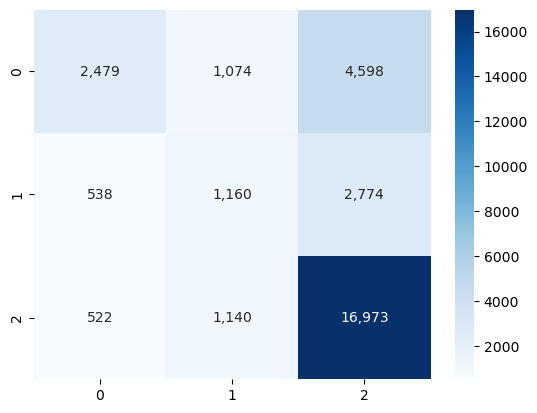

In [35]:
cm = confusion_matrix(df["label"], df["predicted_label"])
sns.heatmap(data=cm,annot=True,fmt=',d',cmap='Blues')

### Predictions analysis (Roi persepective, softvoting)

In [38]:
soft_df = df[["label","roi","benign","atypical","malignant"]] \
    .groupby(by=["label","roi"]) \
    .mean() \
    .reset_index()

In [39]:
soft_df.head()

,label,roi,benign,atypical,malignant
0,0,BRACS_1003660_UDH_1.png,0.744550,0.000356,0.255094
1,0,BRACS_1003661_UDH_1.png,0.001495,0.000786,0.997719
2,0,BRACS_1271_PB_11.png,0.122675,0.381689,0.495636
3,0,BRACS_1271_PB_12.png,0.147568,0.429682,0.422750
4,0,BRACS_1271_UDH_13.png,0.072766,0.222207,0.705028


In [45]:
soft_df["predicted_label"] = np.argmax(soft_df[['benign','atypical','malignant']].values, axis=1)

In [46]:
soft_df.head()

,label,roi,benign,atypical,malignant,predicted_label
0,0,BRACS_1003660_UDH_1.png,0.744550,0.000356,0.255094,0
1,0,BRACS_1003661_UDH_1.png,0.001495,0.000786,0.997719,2
2,0,BRACS_1271_PB_11.png,0.122675,0.381689,0.495636,2
3,0,BRACS_1271_PB_12.png,0.147568,0.429682,0.422750,1
4,0,BRACS_1271_UDH_13.png,0.072766,0.222207,0.705028,2


In [47]:
compute_metrics(metrics, soft_df["label"], soft_df["predicted_label"])

accuracy           0.451923
precision_macro    0.591806
precision_micro    0.451923
recall_macro       0.486292
recall_micro       0.451923
f1_macro           0.412055
f1_micro           0.451923
dtype: float64

<Axes: >

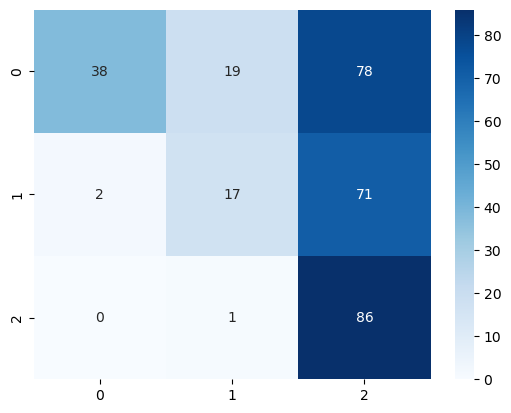

In [48]:
cm = confusion_matrix(soft_df["label"], soft_df["predicted_label"])
sns.heatmap(data=cm,annot=True,fmt=',d',cmap='Blues')

### Predictions analysis (Roi persepective, hardvoting)